In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from src.geometry.point_transformation import *
from src.splats.splats_utils import *

### Gaussian function

Gaussian function with mean $\mu \in R^{n}$ and covariance $\Sigma$ is given by

$$ G(x) = exp({-\frac{1}{2}(x - \mu)^T} \Sigma^{-1} (x - \mu))$$

This can be used to compute the strength that a given splat has on a given pixel

However, this only works when $\Sigma$ is positive-definite, which may not be true during gradient descent updates

In [70]:
white_data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=1000)

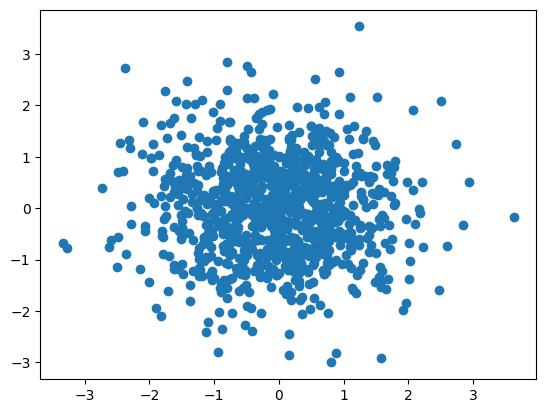

In [71]:
plt.scatter(white_data[:, 0], white_data[:, 1])

Some algebra is needed to perform transformations 

For eigenvectors and eigenvalues of a matrix $A$ it is true that 

$$A v = \lambda v$$

where $v$ is an eigenvector and $\lambda$ is a corresponding eigenvalue

In [72]:
cov = [[3, 2], [2, 3]]
eigenvalues, eigenvectors = np.linalg.eig(cov)

v = eigenvectors[:, 0]
lambd = eigenvalues[0]

lhs = cov @ v 
rhs = lambd * v

print(f"LHS = {lhs}")
print(f"RHS = {rhs}")
print(np.allclose(lhs, rhs))

LHS = [3.53553391 3.53553391]
RHS = [3.53553391 3.53553391]
True


If we have white data $D$ defined as above, then we can apply a transformation $T$ consisting of rotation $R$ and scaling $S$ ($T = RS$) to get new data $D'$. It relates covariance matrix as follows $$\Sigma = TIT^{T}$$ $$\Sigma = RS(RS)^{T}$$ $$\Sigma = RSS^TR^T$$

How does it relate to eigenvalues & eigenvectors?

$$\Sigma V = V L$$ where $V$ is a matrix of *eigenvectors* and $L$ is a diagonal matrix of *eigenvalues*

$$\Sigma = V L V^{-1}$$

It is the eigendecomposition of the covariance matrix, where $R = V$ and $S = \sqrt{L}$

In [73]:
cov = np.array([[3, 2], [2, 3]])
eigenvalues, eigenvectors = np.linalg.eig(cov)

In [74]:
eigenvalues

array([5., 1.])

In [75]:
eigenvectors

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [76]:
R = eigenvectors
S = np.sqrt(np.diag(eigenvalues))
print(R)
print(S)
new_cov = R @ S @ S.T @ R.T
print(new_cov)
np.allclose(new_cov, cov) # same as original one

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[2.23606798 0.        ]
 [0.         1.        ]]
[[3. 2.]
 [2. 3.]]


True

In [77]:
from torch.linalg import eigvals, eig
import torch 

cov_pt = torch.tensor([[1, 0, 0], [0, 2, 0], [0, 0, 3.0]])
print(eigvals(cov_pt)) # no specific order is guaranteed
print(eig(cov_pt))

tensor([1.+0.j, 2.+0.j, 3.+0.j])
torch.return_types.linalg_eig(
eigenvalues=tensor([1.+0.j, 2.+0.j, 3.+0.j]),
eigenvectors=tensor([[1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j]]))


In [78]:
transformed_data = white_data @ S @ R.T

In [79]:
transformed_data

array([[ 2.03455254,  0.27126759],
       [ 1.99162812,  0.96582797],
       [-2.0254655 , -0.21661236],
       ...,
       [-1.97182269, -2.82697114],
       [-2.51439081, -1.99563478],
       [-0.20881174,  0.37694197]])

In [80]:
data = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=1000)

Data obtained by transformation of the white data D' and the data drawn from the distribution are aligned so we're good here

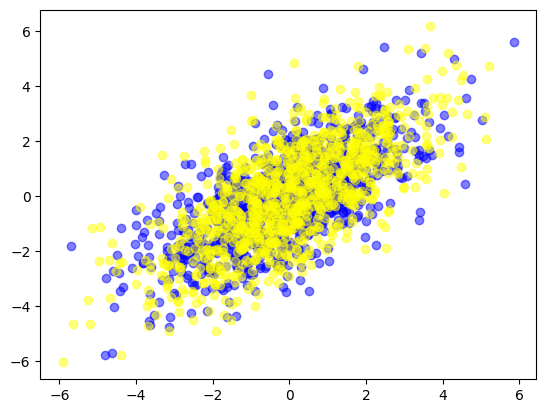

In [81]:
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5, color='blue')
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='yellow')

Inversion of 2D matrix

In [82]:
def inverse_cov_2d(cov):
    det = cov[0, 0] * cov[1, 1] - cov[0, 1] * cov[1, 0]
    return 1 / det * np.array([[cov[1, 1], -cov[0, 1]], [-cov[1, 0], cov[0, 0]]])

In [83]:
inverse_cov_2d(cov)

array([[ 0.6, -0.4],
       [-0.4,  0.6]])

In [84]:
LA.inv(cov)

array([[ 0.6, -0.4],
       [-0.4,  0.6]])

In [85]:
def gaussian_weight_2d(x, mu, cov):
    return np.exp(-1/2 * (x - mu).T @ inverse_cov_2d(cov) @ (x - mu))

In [86]:
mean = np.array([0, 0])
cov = np.array([[3, 2], [2, 3]])
x = np.array([3, 3])

In [87]:
gaussian_weight_2d(x, mean, cov)

np.float64(0.1652988882215865)

In [88]:
x = np.linspace(-4, 4, 20)
y = np.linspace(-4, 4, 20)
X, Y = np.meshgrid(x, y)
arr = np.vstack((X.ravel(), Y.ravel())).T

Puzzle - how to vectorize this multiplication?

In [89]:
weights = np.array([gaussian_weight_2d(x, mean, cov) for x in arr])

Validate results

(-4.0, 4.0)

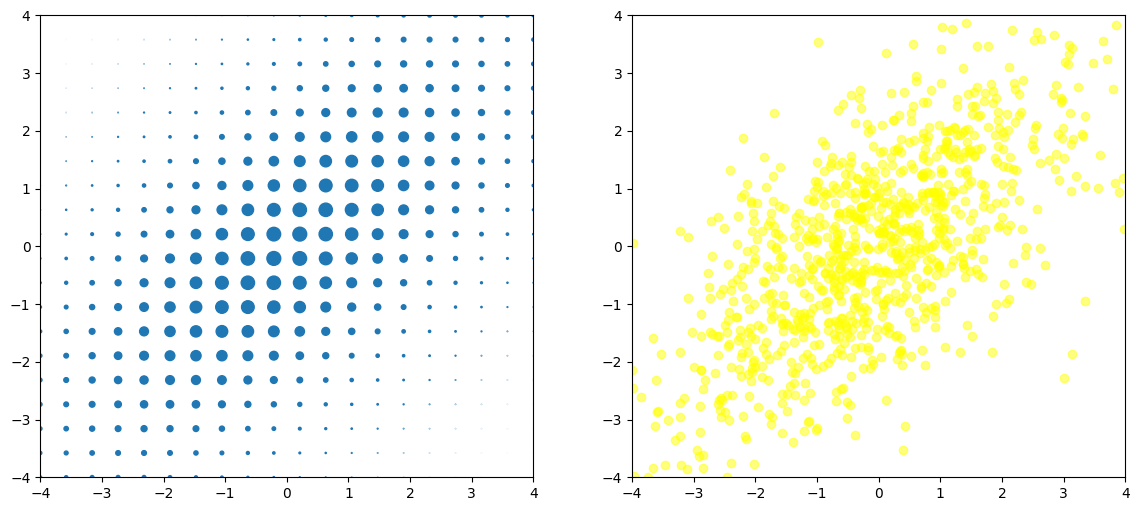

In [90]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(arr[:, 0], arr[:, 1], s=weights * 100)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
data = np.random.multivariate_normal(mean=mean, cov=cov, size=1000)
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, color='yellow')
plt.xlim(-4, 4)
plt.ylim(-4, 4)

### Projecting 3D Covariance onto 2D 

Our projection of 3D Gaussians also means we need to project their covariances

following tutorial: https://shi-yan.github.io/how_to_render_a_single_gaussian_splat/

In general, if we want to apply $V$ transformation to a covariance matrix $\Sigma$, then 

$$\Sigma' = V \Sigma V^{T}$$

In [91]:
scene_folder = Path('../data/south-building')
images_folder = scene_folder / 'images'
database_path = scene_folder / 'database.db'

reconstruction = pycolmap.Reconstruction(scene_folder / '0')
camera = reconstruction.cameras[1]
img_id = 60
img = reconstruction.images[img_id]
img_name = img.name

In [92]:
width, height = camera.width, camera.height

In [93]:
extrinsic_params = get_extrinsic_params(get_camera_from_image(img))
print(extrinsic_params)

[[ 0.65883531 -0.16565849 -0.73382103  1.29975755]
 [ 0.21772808  0.97569481 -0.02478149  1.12463341]
 [ 0.72009063 -0.14344652  0.6788907   3.4804925 ]
 [ 0.          0.          0.          1.        ]]


In [94]:
viewing_transformation = extrinsic_params[:3, :3].T # LA.inv(extrinsic_params[:3, :3])
viewing_transformation

array([[ 0.65883531,  0.21772808,  0.72009063],
       [-0.16565849,  0.97569481, -0.14344652],
       [-0.73382103, -0.02478149,  0.6788907 ]])

In [95]:
cov3D = np.array([[1, 2, 3], [2, 3, 2], [1, 1, 1]])

Viewing transformation is used to transform from object space to camera coordinates

In [96]:
variance_in_camera_coordinates = viewing_transformation @ cov3D @ viewing_transformation.T
variance_in_camera_coordinates

array([[ 4.03663522,  1.87569168,  0.72820407],
       [ 2.55994973,  1.93260467, -0.37591142],
       [-1.38884404, -0.59929057, -0.96923988]])

### Perspective Projection

https://www.songho.ca/opengl/gl_projectionmatrix.html

In perspective projection, a 3D point in a truncated pyramid frustum (eye coordinates) is mapped to a cube (NDC). (This is the same transformation as in **Point Cloud Projection** notebook)

<div>
<img src="images/gl_projectionmatrix01.png" width="500">
</div>

A 3D point is projected onto **near** plane in eye space (2D). The following show how point $(x_e, y_e, z_e)$ is projected to $(x_p, y_p, z_p)$ on the near space.

<div>
<img src="images/gl_projectionmatrix03.png" width="500">
<img src="images/gl_projectionmatrix04.png" width="500">
</div>

Using the ratio of similar triangles, we calculate:

$$x_p = \frac{n * x_e}{-z_e}$$
$$y_p = \frac{n * y_e}{-z_e}$$
$$z_p = -n$$

However, this transformation can't be represented by 3x3 matrix so we'll need to use it's approximation. We'll need to find Jacobian matrix 

$$ J = \begin{pmatrix}
 \frac{x_p}{x_e} & \frac{y_p}{x_e} & \frac{z_p}{x_e} \\
 \frac{x_p}{y_e} & \frac{y_p}{y_e} & \frac{z_p}{y_e} \\
 \frac{x_p}{z_e} & \frac{y_p}{z_e} & \frac{z_p}{z_e} 
 \end{pmatrix}
 $$
 
$$J = \begin{pmatrix} 
\frac{-n}{z_e} & 0 & 0 \\
0 & -\frac{n}{z_e} & 0 \\
\frac{x_e}{z_e^{2}} & \frac{y_e}{z_e^{2}} & 0
\end{pmatrix}$$

This matrix is used to transform 3x3 covariance matrix

In [97]:
# Not sure about this one so the inner formula may need to be changed
def get_jacobian_matrix(point: np.array, znear):
    J = np.zeros((3, 3))
    J[0, 0] = -znear / point[2]
    J[1, 1] = -znear / point[2]
    J[2, 0] = point[0] / point[2] ** 2
    J[2, 1] = point[1] / point[2] ** 2
    return J 

In [98]:
homogenous_points = convert_to_homogenous(get_points_xyz(reconstruction)).T
projected_to_camera_viewpoint = (extrinsic_params @ homogenous_points).T

In [99]:
jac = get_jacobian_matrix(projected_to_camera_viewpoint[0, :3], 0.1)

In [100]:
jac

array([[-0.03228303,  0.        ,  0.        ],
       [ 0.        , -0.03228303,  0.        ],
       [ 0.15443729,  0.05212275,  0.        ]])

In [101]:
cov = np.array([[3, 1, 1], [0, 3, 0], [1, 1, 3]])

Projecting 3D covariance to 2D - and then we only need upper-left square

In [102]:
projected_cov = jac @ viewing_transformation @ cov @ viewing_transformation.T @ jac.T

In [103]:
projected_cov[:2, :2]

array([[ 0.00442836,  0.00117936],
       [-0.00029296,  0.0028618 ]])

### Bounding box for a splat

Bounding box will be used during rasterization to decide whether a given pixel can be affected at all by a splat.

We'll use the largest eigenvalue to evaluate the extent of influence

In [104]:
cov_2d = np.array([[3, 2], [4, 6]])
mu = np.array([5, 5])

In [105]:
get_bounding_box(mu, cov_2d)

array([13.32550654, -3.32550654, 13.32550654, -3.32550654])

[7.70156212 1.29843788] [[-0.76164568 -0.39144501]
 [ 0.64799372 -0.9202015 ]] [[-0.39144501 -0.76164568]
 [-0.9202015   0.64799372]]
[1. 1.]


C:\Users\julia\AppData\Local\Temp\ipykernel_40232\3237830728.py:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean=mu, cov=cov_2d, size=1000)


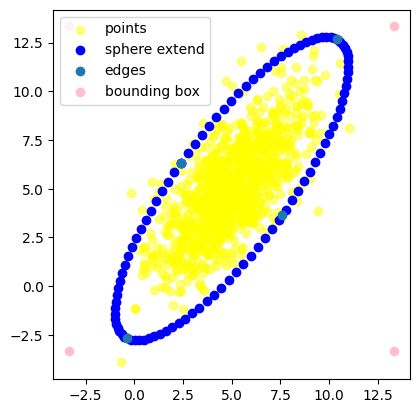

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Define the circle parameters
r = 1  # radius
theta = np.linspace(0, 2 * np.pi, 100)  # 100 points between 0 and 2pi

# Parametric equations for the circle
x = r * np.cos(theta)
y = r * np.sin(theta)

extend_factor = 3

eigenvalues, eigenvectors = LA.eig(cov_2d)
print(eigenvalues[::-1], eigenvectors, eigenvectors[:, [1, 0]])
print(np.sign(eigenvalues))
sphere_points = np.stack((x, y), axis=0).reshape(2, -1)
sphere_points = (eigenvectors.T @ (np.diag(np.sqrt(np.abs(eigenvalues))) * extend_factor) @ sphere_points).T

data = np.random.multivariate_normal(mean=mu, cov=cov_2d, size=1000)
plt.scatter(data[:, 0], data[:, 1], color='yellow', alpha=0.5, label='points')
plt.scatter(mu[0] + sphere_points[:, 0], (mu[1] - sphere_points[:, 1]), color='blue', label='sphere extend')
edge_points = np.array([
    [0, 1], 
    [1, 0],
    [0, -1],
    [-1, 0]
])

R = eigenvectors
edge_points = (R.T @ np.diag(np.sqrt(eigenvalues)* extend_factor) @ edge_points.T).T

plt.scatter(mu[0] + edge_points[:, 0], mu[1] -edge_points[:, 1], label='edges')

x_max, x_min, y_max, y_min = get_bounding_box(mu, cov_2d)
bounding_box = np.array([
    [x_max, y_max], [x_max, y_min], [x_min, y_max], [x_min, y_min]
])
plt.scatter(bounding_box[:, 0], bounding_box[:, 1], color='pink', label='bounding box') # bounding box points

# Set the aspect ratio to equal to ensure the circle isn't distorted
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.legend()
plt.show()

A way to filter out pixels that are affected by a gaussian

Remember that a pixel is here an array of rgb color $[r, g, b]$ and it's index in an array is its coordinate

The code below is more like a sketch (pbly there is a smarter way) but it shows the idea

In [107]:
arr = np.random.rand(20, 20, 3)
pixels_within_bb_ids(arr, mu, cov_2d, extent=3.0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,

Simple method that flattens the image array (ex. 20x20 pixels image) and just has for each pixel its coordinate $[row, col]$

In [108]:
get_pixel_coords(arr)

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 0, 15],
       [ 0, 16],
       [ 0, 17],
       [ 0, 18],
       [ 0, 19],
       [ 1,  0],
       [ 1,  1],
       [ 1,  2],
       [ 1,  3],
       [ 1,  4],
       [ 1,  5],
       [ 1,  6],
       [ 1,  7],
       [ 1,  8],
       [ 1,  9],
       [ 1, 10],
       [ 1, 11],
       [ 1, 12],
       [ 1, 13],
       [ 1, 14],
       [ 1, 15],
       [ 1, 16],
       [ 1, 17],
       [ 1, 18],
       [ 1, 19],
       [ 2,  0],
       [ 2,  1],
       [ 2,  2],
       [ 2,  3],
       [ 2,  4],
       [ 2,  5],
       [ 2,  6],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 11],
       [ 2, 12],
       [ 2, 13],
       [ 2, 14],
       [ 2, 15],
       [ 2, 16],
       [ 2, 17],
       [ 2, 18

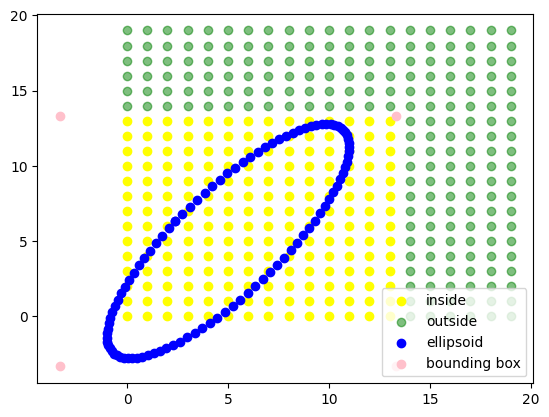

In [109]:
arr = np.random.rand(20, 20, 3)

ids = pixels_within_bb_ids(arr, mu, cov_2d, extent=3.0)
pixel_coords = get_pixel_coords(arr)
points = pixel_coords[ids] # filter out pixels within gaussian splat bb

plt.scatter(points[:, 0], points[:, 1], c='yellow', label='inside')
plt.scatter(pixel_coords[~ids, 0], pixel_coords[~ids, 1], color='green', alpha=0.5, label='outside')
plt.scatter(mu[0] + sphere_points[:, 0], (mu[1] - sphere_points[:, 1]), color='blue', label='ellipsoid')
plt.scatter(bounding_box[:, 0], bounding_box[:, 1], color='pink', label='bounding box') 

plt.legend()

### YOU CAN FINISH READING HERE

In [110]:
idx = 100
l, h = 0.01, 0.05
mu = np.array([5, 5])
cov = np.random.uniform(low=l, high=h, size=(3, 3)) @ np.array([[1, 1, 1], [0, 1, 1], [0, 0, 1]])
cov = cov + cov.T

In [111]:
from scipy.linalg import issymmetric

In [112]:
print(issymmetric(cov))
cov

True


array([[0.03149211, 0.05612629, 0.0945106 ],
       [0.05612629, 0.10471344, 0.15996009],
       [0.0945106 , 0.15996009, 0.16531058]])

In [113]:
print("Bounding box coordinates: ", get_bounding_box(mu, cov))
print("Number of intersecting pixels: ", np.sum(pixels_within_bb_ids(arr, mu, cov)))

Bounding box coordinates:  [6.74043345 3.25956655 6.74043345 3.25956655]
Number of intersecting pixels:  9


In [114]:
cov_2 = np.array([[ 6.00863742e-03, -1.38604570e-03, -2.20416546e-04],
        [-1.38604570e-03,  5.85609706e-03, -1.24907830e-03],
        [-2.20416546e-04, -1.24907830e-03,  7.16912654e-03]])
print("Bounding box coordinates: ", get_bounding_box(mu, cov_2))
print("Number of intersecting pixels: ", np.sum(pixels_within_bb_ids(arr, mu, cov_2)))

Bounding box coordinates:  [5.27009134 4.72990866 5.27009134 4.72990866]
Number of intersecting pixels:  1


In [115]:
upper_ones = np.array([[1, 1, 1], [0, 1, 1], [0, 0, 1]])
upper_ones = np.repeat(upper_ones[np.newaxis, :], 10, axis=0)

In [116]:
init_from_uniform(0.01, 0.1, 10)

array([[[0.05263303, 0.16964614, 0.29279571],
        [0.16964614, 0.21477336, 0.30975016],
        [0.29279571, 0.30975016, 0.36103307]],

       [[0.07923692, 0.1264796 , 0.16021534],
        [0.1264796 , 0.206408  , 0.24129864],
        [0.16021534, 0.24129864, 0.16970159]],

       [[0.15619327, 0.17106917, 0.2327768 ],
        [0.17106917, 0.19007375, 0.19734435],
        [0.2327768 , 0.19734435, 0.24360199]],

       [[0.07417902, 0.20804008, 0.22081437],
        [0.20804008, 0.31095588, 0.33715602],
        [0.22081437, 0.33715602, 0.3230784 ]],

       [[0.18280352, 0.15744582, 0.28554491],
        [0.15744582, 0.08786419, 0.18506297],
        [0.28554491, 0.18506297, 0.31109481]],

       [[0.04637552, 0.15845602, 0.20515225],
        [0.15845602, 0.16790974, 0.29474532],
        [0.20515225, 0.29474532, 0.30231216]],

       [[0.15412734, 0.1413844 , 0.21386714],
        [0.1413844 , 0.14363741, 0.23903677],
        [0.21386714, 0.23903677, 0.24838692]],

       [[0.13609913,

In [117]:
arr_3d = np.random.uniform(low=0.1, high=0.5, size=(5, 3, 3))

In [118]:
arr_3d[0]

array([[0.10758941, 0.48385589, 0.41448606],
       [0.14338934, 0.15579071, 0.48832611],
       [0.25316975, 0.39604679, 0.40946358]])

In [119]:
arr_3d.transpose((0, 2, 1))[0].T

array([[0.10758941, 0.48385589, 0.41448606],
       [0.14338934, 0.15579071, 0.48832611],
       [0.25316975, 0.39604679, 0.40946358]])

In [120]:
init_from_uniform(0.01, 0.1, 30)

array([[[0.07596685, 0.09303618, 0.17345141],
        [0.09303618, 0.20229189, 0.21939473],
        [0.17345141, 0.21939473, 0.33782862]],

       [[0.11423643, 0.15593065, 0.18971488],
        [0.15593065, 0.17953974, 0.23430184],
        [0.18971488, 0.23430184, 0.29953045]],

       [[0.15552535, 0.19275329, 0.19677117],
        [0.19275329, 0.241347  , 0.33053187],
        [0.19677117, 0.33053187, 0.3723278 ]],

       [[0.02561221, 0.12447969, 0.1298266 ],
        [0.12447969, 0.21580514, 0.2135875 ],
        [0.1298266 , 0.2135875 , 0.35710878]],

       [[0.14786267, 0.17353393, 0.17548508],
        [0.17353393, 0.18466547, 0.21158312],
        [0.17548508, 0.21158312, 0.24134433]],

       [[0.15086072, 0.18655815, 0.26753707],
        [0.18655815, 0.16600195, 0.22326536],
        [0.26753707, 0.22326536, 0.31421109]],

       [[0.12491461, 0.11059021, 0.16969662],
        [0.11059021, 0.12735232, 0.24053134],
        [0.16969662, 0.24053134, 0.30432863]],

       [[0.09638155,

In [121]:
# shit code, skip it
eigenvalues, eigenvectors = LA.eig(cov_2d)
R = eigenvectors
L = np.sqrt(np.diag(eigenvalues))
edge_points = np.array([
    [0, 1], 
    [1, 0],
    [0, -1],
    [-1, 0]
])
edge_points = edge_points @ L @ R.T
x, y = edge_points[1, 0], edge_points[1, 1]
sin_phi = y / L[0, 0]

phi = np.arcsin(sin_phi)
print(f"Angle of ellipsoid is {np.rad2deg(phi):.2f}")

tan_t1 = - L[1, 1] * np.tan(phi) / L[0, 0]
tan_t2 = L[1, 1] / (np.tan(phi) * L[0, 0])
print(f"Tan t1 {tan_t1:.2f} t2 {tan_t2:.2f}")

t1 = np.arctan(tan_t1)
t2 = np.arctan(tan_t2)
print(f"t1 {tan_t1:.2f} t2 {tan_t2:.2f}")

x1 = L[0, 0] * np.cos(t1) * np.cos(phi) - L[1, 1] * np.sin(t1) * np.sin(phi)
x2 = L[0, 0] * np.cos(t2) * np.cos(phi) - L[1, 1] * np.sin(t2) * np.sin(phi)
print(x1, x2)

y1 = L[1, 1] * np.sin(t1) * np.cos(phi) + L[0, 0] * np.cos(t1) * np.sin(phi)
y2 = L[1, 1] * np.sin(t2) * np.cos(phi) + L[0, 0] * np.cos(t2) * np.sin(phi)
print(y1, y2)

Angle of ellipsoid is 40.39
Tan t1 -2.07 t2 2.86
t1 -2.07 t2 2.86
1.9967681967764097 -1.4114661263928963
-1.582661566624196 2.238954391751267


In [122]:
sphere_points[:2]

array([[-2.60366333, -1.33814322],
       [-2.25625713, -1.82134887]])

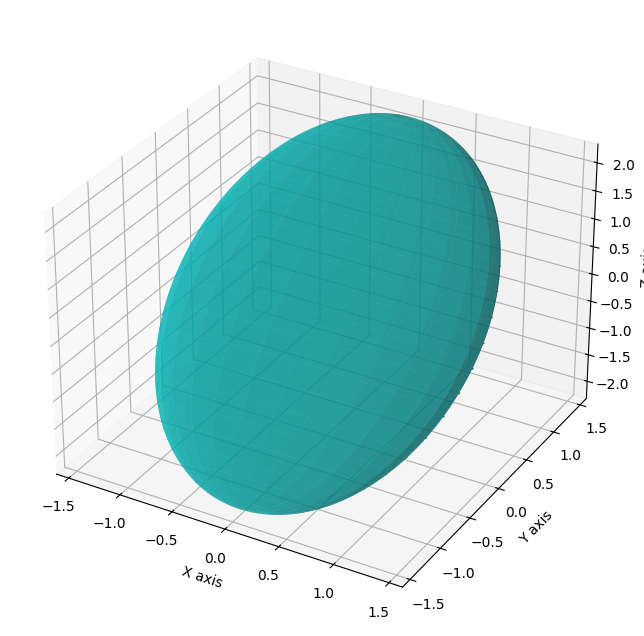

In [123]:
# Generated by chatgpt
import numpy as np
import matplotlib.pyplot as plt

cov = np.array([[2, 0, 0], [0, 2, 0], [0, 3, 5]])

# Step 2: Compute eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov)

# Step 3: Generate a sphere
# Create a grid of points that forms a unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Stack the sphere points into a 3xN array (for matrix multiplication)
sphere_points = np.stack((x, y, z), axis=0).reshape(3, -1)

# Step 4: Transform the unit sphere into the ellipsoid using the covariance matrix
# Scale the sphere points by the eigenvalues and rotate them using the eigenvectors
ellipsoid_points = eigvecs @ np.diag(np.sqrt(eigvals)) @ sphere_points

# Reshape to 3D for plotting
x_ellipsoid = ellipsoid_points[0, :].reshape(100, 100)
y_ellipsoid = ellipsoid_points[1, :].reshape(100, 100)
z_ellipsoid = ellipsoid_points[2, :].reshape(100, 100)

# Step 5: Plot the ellipsoid
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the ellipsoid
ax.plot_surface(x_ellipsoid, y_ellipsoid, z_ellipsoid, color='c', alpha=0.6, rstride=4, cstride=4, linewidth=0.5)

# Add labels and set equal aspect ratio
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()